In [ ]:
import os
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import pandana as pdna
import pandas as pd
from pandas.api.typing import DataFrameGroupBy

from nad.accessibility import create_network, get_accessibility_metrics
from nad.load import (
    get_census_level,
    load_ageb_geometry,
    load_all_equipments,
    load_block_geometry,
    load_census,
)

In [2]:
data_path = Path(os.environ["DATA_PATH"])
geostatistical_framework_path = Path(os.environ["GEOSTATISTICAL_FRAMEWORK_PATH"])
population_grids_path = Path(os.environ["POPULATION_GRIDS_PATH"])
census_path = Path(os.environ["CENSUS_PATH"])

cache_path = Path("./cache")
results_path = Path("./results")

# Constants

In [3]:
ADJUSTMENT_FACTOR = 3
WALK_SPEED = 5  # km/h
MAX_DISTANCE = 10_000  # aprox 2 hour of walking
NUM_POIS = 5

EQUIPAMIENTOS = {
    "guarderia": {"radius": 750, "weight": 1, "category_type": "educacion"},
    "preescolar": {"radius": 750, "weight": 1, "category_type": "educacion"},
    "primaria": {"radius": 500, "weight": 1, "category_type": "educacion"},
    "secundaria": {"radius": 1_000, "weight": 1, "category_type": "educacion"},
    "preparatoria": {"radius": 5_000, "weight": 1, "category_type": "educacion"},
    "universidad": {"radius": 50_000, "weight": 1, "category_type": "educacion"},
    "parque": {"radius": 670, "weight": 1, "category_type": "parque"},
    "auditorio": {"radius": 1_000, "weight": 1, "category_type": "recreacion"},
    "biblioteca": {"radius": 10_000, "weight": 1, "category_type": "recreacion"},
    "cine": {"radius": 1_500, "weight": 1, "category_type": "recreacion"},
    "unidad_deportiva": {"radius": 10_000, "weight": 1, "category_type": "recreacion"},
    "hospital": {"radius": 50_000, "weight": 1, "category_type": "salud"},
    "centro_salud": {"radius": 1_000, "weight": 1, "category_type": "salud"},
}

# Datos

## Equipamientos

In [4]:
df_equip = load_all_equipments(data_path).assign(
    capacity=1,
    geometry=lambda df: df["geometry"].centroid,
)

## AGEBs

In [5]:
df_geom_agebs = load_ageb_geometry(
    population_grids_path / "final" / "zone_agebs" / "shaped" / "2020" / "08.2.03.gpkg",
)

## Manzanas

In [6]:
df_census_base = load_census(census_path / "2020" / "08.csv")
df_census_blocks = get_census_level(df_census_base, level="block")

df_geom_blocks = load_block_geometry(
    geostatistical_framework_path / "2020" / "08_chihuahua" / "08m.shp",
    ageb_cvegeos=df_geom_agebs.index,
)

df_blocks = df_geom_blocks.join(df_census_blocks, how="inner").filter(
    ["POBTOT", "TVIVPARHAB", "CVEGEO_AGEB", "geometry"],
)

# Stats

In [7]:
net_path = cache_path / f"network_{hash(MAX_DISTANCE)}.h5"

if not net_path.exists():
    gdf_vialidades = gpd.read_file(
        data_path / "datos" / "Vialidad" / "VialidadWgs84.shp",
    ).to_crs(
        "EPSG:6372",
    )
    net = create_network(gdf_vialidades, net_path, MAX_DISTANCE)
else:
    net = pdna.Network.from_hdf5(net_path)

Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 59942
Setting CH edge vector of size 82670
Range graph removed 182 edges of 165340
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [8]:
coords = df_blocks.centroid.get_coordinates()
df_blocks_accessibility = (
    df_blocks.assign(origin_id=net.get_node_ids(coords["x"], coords["y"]))
    .reset_index()
    .set_index("origin_id")
)

In [9]:
scores = []
for nombre, item in EQUIPAMIENTOS.items():
    df_temp = df_equip.query("equipamiento == @nombre").assign(capacity=1)
    accessibility_scores = get_accessibility_metrics(
        net,
        df_temp,
        df_blocks_accessibility["POBTOT"],
        nombre,
        MAX_DISTANCE,
        NUM_POIS,
        WALK_SPEED,
        item["radius"],
        ADJUSTMENT_FACTOR,
    ).assign(category=nombre)
    scores.append(accessibility_scores)

scores = pd.concat(scores)

In [ ]:
test = pd.DataFrame([1, 2, 3])
x = test.groupby()

In [ ]:
def normalize_and_clip_outliers(group: DataFrameGroupBy) -> DataFrameGroupBy:
    q3 = group["accessibility_score"].quantile(0.9)
    upper_bound = q3 + 1.5 * q3

    group["accessibility_score"] = group["accessibility_score"].clip(0, upper_bound)
    group["accessibility_score"] = (
        group["accessibility_score"] - group["accessibility_score"].min()
    ) / (group["accessibility_score"].max() - group["accessibility_score"].min())
    return group


final_score = (
    scores.groupby(["origin_id", "category"])
    .agg({"accessibility_score": "sum"})
    .reset_index()
)
final_score = final_score.groupby("category", group_keys=False).apply(
    normalize_and_clip_outliers
)
final_score["accessibility_score"] = final_score.apply(
    lambda x: x["accessibility_score"] * EQUIPAMIENTOS[x["category"]]["weight"], axis=1
)
final_score = (
    final_score.groupby("origin_id", group_keys=False)
    .agg({"accessibility_score": "sum"})
    .reset_index()
)
final_score["accessibility_score"] = final_score["accessibility_score"] / len(
    EQUIPAMIENTOS
)
final_score

/var/folders/yq/0mz24vy927s9m5vjh6gqb6040000gn/T/ipykernel_24334/2419582325.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "category", group_keys=False).apply(normalize_and_clip_outliers)


,origin_id,accessibility_score
0,0,0.056754
1,1,0.049377
2,2,0.056258
3,3,0.061207
4,4,0.046861
...,...,...
59937,59937,0.000000
59938,59938,0.384615
59939,59939,0.000000
59940,59940,0.000000


In [11]:
results = df_blocks_accessibility.join(final_score)

df_blocks_accessibility = (
    df_blocks_accessibility.assign(
        accessibility_score=results["accessibility_score"],
    )
    .reset_index()
    .set_index("CVEGEO")
)

<Axes: >

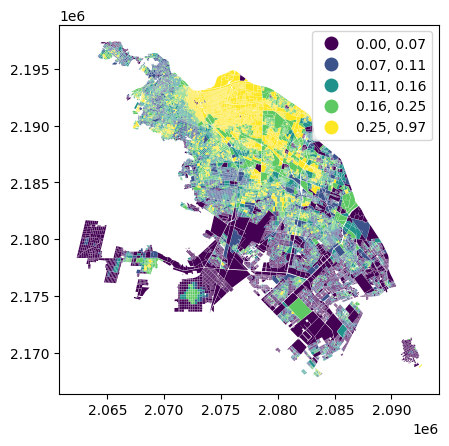

In [12]:
df_blocks_accessibility.plot(
    column="accessibility_score",
    scheme="quantiles",
    k=5,
    legend=True,
)

In [13]:
df_blocks_accessibility.to_file(results_path / "accesibilidad.fgb")

In [14]:
temp = df_blocks_accessibility.join(scores[["time", "category"]], on="origin_id")

parque = temp.query("category == 'parque'")

manzanas_clinica_hospital = (
    temp[temp["category"].isin(["centro_salud", "hospital"])]
    .groupby("CVEGEO")
    .agg({"time": "min", "TVIVPARHAB": "first"})
)

preparatoria = temp.query("category == 'preparatoria'")

df_blocks_accessibility = df_blocks_accessibility.assign(
    tiempo_parque=parque["time"],
    tiempo_clinica_hospital=manzanas_clinica_hospital["time"],
    tiempo_preparatoria=preparatoria["time"],
    hogares_parque_15mi=parque[parque["time"] <= 15]["TVIVPARHAB"].fillna(0),
    hogares_clinica_hospital_30mi=manzanas_clinica_hospital[
        manzanas_clinica_hospital["time"] <= 30
    ]["TVIVPARHAB"].fillna(0),
    hogares_preparatoria_30mi=preparatoria[preparatoria["time"] <= 30][
        "TVIVPARHAB"
    ].fillna(0),
)

df_blocks_accessibility.to_file(results_path / "accessibility_blocks.gpkg")

array([[<Axes: title={'center': 'accessibility_score'}>]], dtype=object)

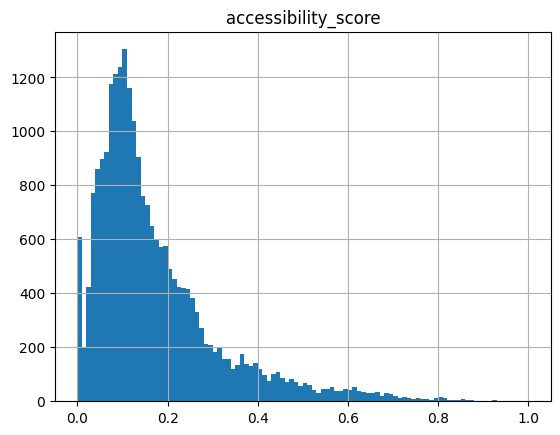

In [15]:
df_blocks_accessibility.hist(column="accessibility_score", bins=100, range=(0, 1))

(2060080.966024646, 2108800.9246823997, 2145072.2086611725, 2199916.410778039)

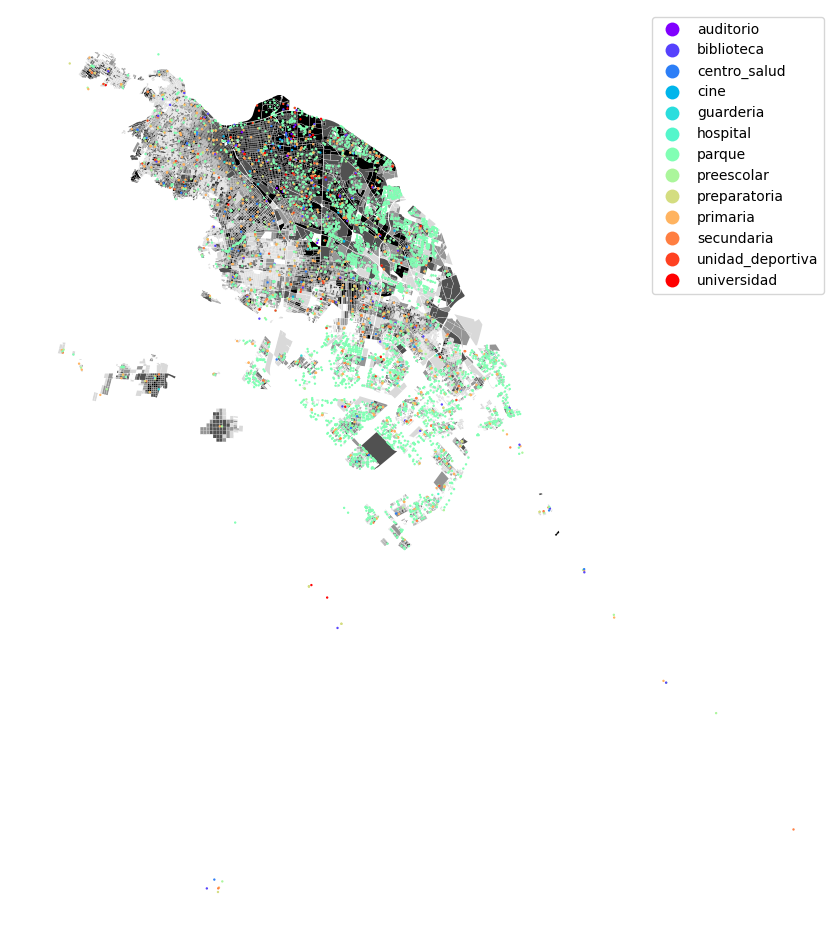

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
df_blocks_accessibility.plot(
    column="accessibility_score",
    scheme="quantiles",
    cmap="Grays",
    k=5,
    legend=True,
    ax=ax,
    lw=0.1,
)
df_equip.plot(ax=ax, markersize=0.5, column="equipamiento", legend=True, cmap="rainbow")
ax.axis("off")